# Imports

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from wordcloud import WordCloud
from src.utils import tratamento, extrair_hora, limpar_descricao
from src.criar_serie import criar_serie_contagem
from src.carga_dados import carregar_dados
from src.funcoes_eda import classificar_turno
from src.ajustes import padronizar_tipo_acidente, padronizar_tipo_evento
import sys
print(sys.executable)

warnings.filterwarnings('ignore')

/Users/flavia.costa/opt/anaconda3/bin/python


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/flavia.costa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/flavia.costa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Carga de dados

In [2]:
df = carregar_dados()

✅ Lido: csvs/acidentes-2019.csv
✅ Lido: csvs/acidentes_2020-novo.csv
✅ Lido: csvs/acidentes-transito-2015.csv
✅ Lido: csvs/acidentes_2016.csv
✅ Lido: csvs/acidentes_2017.csv
✅ Lido: csvs/acidentes_2018.csv
✅ Lido: csvs/acidentes2024.csv
✅ Lido: csvs/acidentes2021.csv
✅ Lido: csvs/acidentes2023.csv
✅ Lido: csvs/acidentes2022.csv

Total de arquivos lidos com sucesso: 10
Total de registros: 72255


# Processamento de dados

In [3]:
df.head()

,DATA,hora,natureza_acidente,situacao,bairro,endereco,numero,detalhe_endereco_acidente,complemento,endereco_cruzamento,...,situacao_placa,velocidade_max_via,mao_direcao,divisao_via1,divisao_via2,divisao_via3,data,natureza,ï»¿data,Protocolo
0,2019-01-01,00:41:00,SEM VÃTIMA,FINALIZADA,IPSEP,AV RECIFE,NaN,NaN,LADO OPOSTO AO NÂº 3257,AV RECIFE,...,NÃ£o hÃ¡ placas,60 km/h,Ãnica,Faixa seccionada,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,01:37:00,SEM VÃTIMA,FINALIZADA,BOA VIAGEM,RUA PADRE BERNADINO PESSOA,NaN,RUA MINISTRO NELSON HUNGRIA,NaN,RUA PADRE BERNADINO PESSOA,...,NÃ£o hÃ¡ placas,NaN,Ãnica,NÃ£o existe,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,14:20:00,SEM VÃTIMA,CANCELADA,BOA VIAGEM,AV ENGENHEIRO DOMINGOS FERREIRA,NaN,RUA DOM JOSE LOPES,"EM FRENTE A DELEGACIA DE BOA VIAGEM, LADO ESQU...",AV ENGENHEIRO DOMINGOS FERREIRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,02:53:00,SEM VÃTIMA,CANCELADA,IMBIRIBEIRA,AV GENERAL MAC ARTHUR,100,RUA JACY,EM FRENTE A ART LED ILUMINAÃÃO,AV GENERAL MAC ARTHUR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,08:17:00,COM VÃTIMA,FINALIZADA,JAQUEIRA,RUA TITO ROSAS,63,NaN,ED. JARDINS DA JAQUEIRA,RUA TITO ROSAS,...,NÃ£o hÃ¡ placas,40 km/h,Ãnica,Faixa seccionada,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Tratar horário
df['hora_limpa'] = df['hora'].apply(extrair_hora)
print(df['hora_limpa'].unique())


[ 0.  1. 14.  2.  8.  9. 13. 15. 16. 17. 19. 20. 21.  6.  7. 11. 12. 18.
 23. 10. 22.  4.  5.  3. nan 48. 29.]


In [5]:
# Tratar descrição para nuvem de palavras
df['descricao_limpa'] = df['descricao'].dropna().apply(limpar_descricao)


In [6]:
print(df.columns)

Index(['DATA', 'hora', 'natureza_acidente', 'situacao', 'bairro', 'endereco',
       'numero', 'detalhe_endereco_acidente', 'complemento',
       'endereco_cruzamento', 'numero_cruzamento', 'referencia_cruzamento',
       'bairro_cruzamento', 'num_semaforo', 'sentido_via', 'tipo', 'descricao',
       'auto', 'moto', 'ciclom', 'ciclista', 'pedestre', 'onibus', 'caminhao',
       'viatura', 'outros', 'vitimas', 'vitimasfatais', 'acidente_verificado',
       'tempo_clima', 'situacao_semaforo', 'sinalizacao', 'condicao_via',
       'conservacao_via', 'ponto_controle', 'situacao_placa',
       'velocidade_max_via', 'mao_direcao', 'divisao_via1', 'divisao_via2',
       'divisao_via3', 'data', 'natureza', 'ï»¿data', 'Protocolo',
       'hora_limpa', 'descricao_limpa'],
      dtype='object')


Tratamento de datas nulas em colunas distintas - Unificação

In [7]:
# Primeiro tenta com dayfirst=True (para datas no formato dd/mm/yyyy)
df['data_dt'] = pd.to_datetime(df['data'], errors='coerce', dayfirst=True)

# Para datas não convertidas, tenta novamente sem dayfirst (formato ISO)
mask = df['data_dt'].isna() & df['data'].notna()
df.loc[mask, 'data_dt'] = pd.to_datetime(df.loc[mask, 'data'], errors='coerce', dayfirst=False)

# Repete para a outra coluna
df['DATA_dt'] = pd.to_datetime(df['DATA'], errors='coerce', dayfirst=True)
mask2 = df['DATA_dt'].isna() & df['DATA'].notna()
df.loc[mask2, 'DATA_dt'] = pd.to_datetime(df.loc[mask2, 'DATA'], errors='coerce', dayfirst=False)

# Agora unifica como antes
df['data_unificada'] = df['data_dt']
mask3 = df['data_unificada'].isna()
df.loc[mask3, 'data_unificada'] = df.loc[mask3, 'DATA_dt']

print("Valores válidos em data_unificada:", df['data_unificada'].notna().sum())


Valores válidos em data_unificada: 60992


In [8]:
tratamento(df)
df.head(10)

,DATA,hora,natureza_acidente,situacao,bairro,endereco,numero,detalhe_endereco_acidente,complemento,endereco_cruzamento,...,divisao_via3,data,natureza,i>>?data,Protocolo,hora_limpa,descricao_limpa,data_dt,DATA_dt,data_unificada
0,2019-01-01,00:41:00,SEM VATIMA,FINALIZADA,IPSEP,AV RECIFE,NaN,NaN,LADO OPOSTO AO NAo 3257,AV RECIFE,...,NaN,NaN,NaN,NaN,NaN,0.0,art obstruaao entrada saada garagem condominio,NaT,2019-01-01,2019-01-01
1,2019-01-01,01:37:00,SEM VATIMA,FINALIZADA,BOA VIAGEM,RUA PADRE BERNADINO PESSOA,NaN,RUA MINISTRO NELSON HUNGRIA,NaN,RUA PADRE BERNADINO PESSOA,...,NaN,NaN,NaN,NaN,NaN,1.0,colisao dois autos,NaT,2019-01-01,2019-01-01
2,2019-01-01,14:20:00,SEM VATIMA,CANCELADA,BOA VIAGEM,AV ENGENHEIRO DOMINGOS FERREIRA,NaN,RUA DOM JOSE LOPES,"EM FRENTE A DELEGACIA DE BOA VIAGEM, LADO ESQU...",AV ENGENHEIRO DOMINGOS FERREIRA,...,NaN,NaN,NaN,NaN,NaN,14.0,colisao dois autos,NaT,2019-01-01,2019-01-01
3,2019-01-01,02:53:00,SEM VATIMA,CANCELADA,IMBIRIBEIRA,AV GENERAL MAC ARTHUR,100,RUA JACY,EM FRENTE A ART LED ILUMINAAAO,AV GENERAL MAC ARTHUR,...,NaN,NaN,NaN,NaN,NaN,2.0,colisao dois autos,NaT,2019-01-01,2019-01-01
4,2019-01-01,08:17:00,COM VATIMA,FINALIZADA,JAQUEIRA,RUA TITO ROSAS,63,NaN,ED. JARDINS DA JAQUEIRA,RUA TITO ROSAS,...,NaN,NaN,NaN,NaN,NaN,8.0,colisao envolvendo anibus bicicleta vatima equ...,NaT,2019-01-01,2019-01-01
5,2019-01-01,09:30:00,COM VATIMA,FINALIZADA,IBURA,AV DOIS RIOS,1392,NaN,IBURA DE BAIXO EM FRENTE A IGREJA PAZ E VIDA,AV DOIS RIOS,...,NaN,NaN,NaN,NaN,NaN,9.0,colisao vitimas socorridas samu,NaT,2019-01-01,2019-01-01
6,2019-01-01,09:54:00,COM VATIMA,FINALIZADA,SAN MARTIN,AV GENERAL SAN MARTIN,1622,NaN,APAS AO BATLHAO DE CAVALARIA DA PMPE,AV GENERAL SAN MARTIN,...,NaN,NaN,NaN,NaN,NaN,9.0,veiculo chocou muro,NaT,2019-01-01,2019-01-01
7,2019-01-01,13:05:00,SEM VATIMA,FINALIZADA,BONGI,EST DO BONGI,290,NaN,EM FRENTE A OFICINA DA FIORI,EST DO BONGI,...,NaN,NaN,NaN,NaN,NaN,13.0,colisao vitimas veiculo embaixo carreta,NaT,2019-01-01,2019-01-01
8,2019-01-01,15:50:00,SEM VATIMA,FINALIZADA,MADALENA,EST DOS REMEDIOS,2360,NaN,E/F A PB AUTOMOVEIS MULTIMARCAS,EST DOS REMEDIOS,...,NaN,NaN,NaN,NaN,NaN,15.0,colisao dois autos,NaT,2019-01-01,2019-01-01
9,2019-01-01,16:01:00,COM VATIMA,CANCELADA,CAMPO GRANDE,EST DE BELEM,NaN,NaN,E/F A IGREJA UNIVERSAL NO ANTIGO TERMINAL DE C...,EST DE BELEM,...,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaT,2019-01-01,2019-01-01


In [9]:
df.shape

(72255, 50)

In [10]:
df['ano'] = df['data_unificada'].dt.year.astype('Int64')  
df['mes'] = df['data_unificada'].dt.month.astype('Int64')
df['dia_semana'] = df['data_unificada'].dt.dayofweek.astype('Int64')



In [11]:
df['ano'].unique()

<IntegerArray>
[2019, 2020, 2015, <NA>, 2017, 2018, 2024, 2025, 2021, 2023, 2022]
Length: 11, dtype: Int64

In [12]:
print(df['bairro'].isnull().sum())
print(df['bairro'].value_counts().head(10))


360
BOA VIAGEM      8960
IMBIRIBEIRA     4330
SANTO AMARO     3516
AFOGADOS        2744
BOA VISTA       2640
MADALENA        2638
DERBY           2006
CASA AMARELA    1992
IPSEP           1922
PINA            1897
Name: bairro, dtype: int64


In [13]:
df['vitimas'] = pd.to_numeric(df['vitimas'], errors='coerce')
df['vitimasfatais'] = pd.to_numeric(df['vitimasfatais'], errors='coerce')
df['auto'] = pd.to_numeric(df['auto'], errors='coerce')
df['moto'] = pd.to_numeric(df['moto'], errors='coerce')
df['ciclom'] = pd.to_numeric(df['ciclom'], errors='coerce')
df['ciclista'] = pd.to_numeric(df['ciclista'], errors='coerce')
df['pedestre'] = pd.to_numeric(df['pedestre'], errors='coerce')
df['onibus'] = pd.to_numeric(df['onibus'], errors='coerce')
df['caminhao'] = pd.to_numeric(df['caminhao'], errors='coerce')
df['viatura'] = pd.to_numeric(df['viatura'], errors='coerce')
df['outros'] = pd.to_numeric(df['outros'], errors='coerce')

Categorias

In [14]:
tipo_veiculos = [
    'auto', 
    'moto', 
    'ciclom', 
    'ciclista', 
    'pedestre', 
    'onibus', 
    'caminhao',
    'viatura', 
    'outros'
]
soma_veiculos = df[tipo_veiculos].sum().astype(int)
print(soma_veiculos.sort_values(ascending=False))


auto        84411
moto        17183
onibus       9315
caminhao     5996
pedestre     1469
ciclista     1011
viatura       803
outros        716
ciclom        424
dtype: int64


Tipo de vitima

In [15]:
tipo_vitima = [
    'vitimas', 
    'vitimasfatais'
]
soma_vitimas = df[tipo_vitima].sum().astype(int).sort_index(ascending=False)
print(soma_vitimas.sort_values(ascending=False))

vitimas          16004
vitimasfatais      175
dtype: int64


Classificação de turno

In [16]:
df['turno'] = df['hora_limpa'].apply(classificar_turno)

In [17]:
df = padronizar_tipo_evento(df, coluna='tipo')
df = padronizar_tipo_acidente(df, coluna='natureza_acidente')


In [18]:
# Define a ordem correta dos dias e turnos
ordem_dias = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
ordem_turnos = ['Madrugada', 'Manhã', 'Tarde', 'Noite', 'Indefinido']

# Mapeia os dias
df['dia_nome'] = df['dia_semana'].map(dict(enumerate(ordem_dias)))

# Converte para categorias ordenadas
df['dia_nome'] = pd.Categorical(df['dia_nome'], categories=ordem_dias, ordered=True)
df['turno'] = pd.Categorical(df['turno'], categories=ordem_turnos, ordered=True)



Gráficos exploratórios

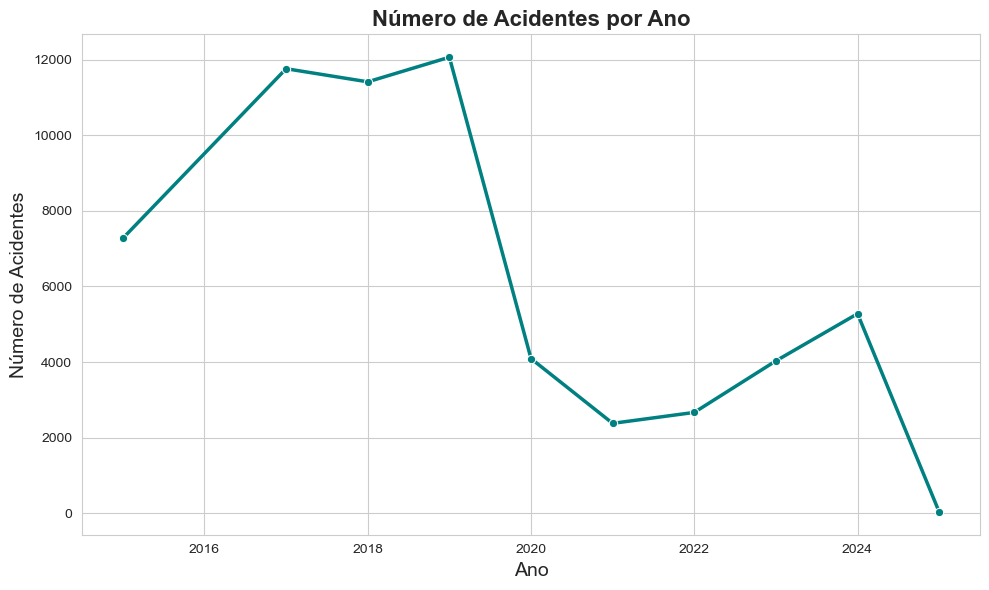

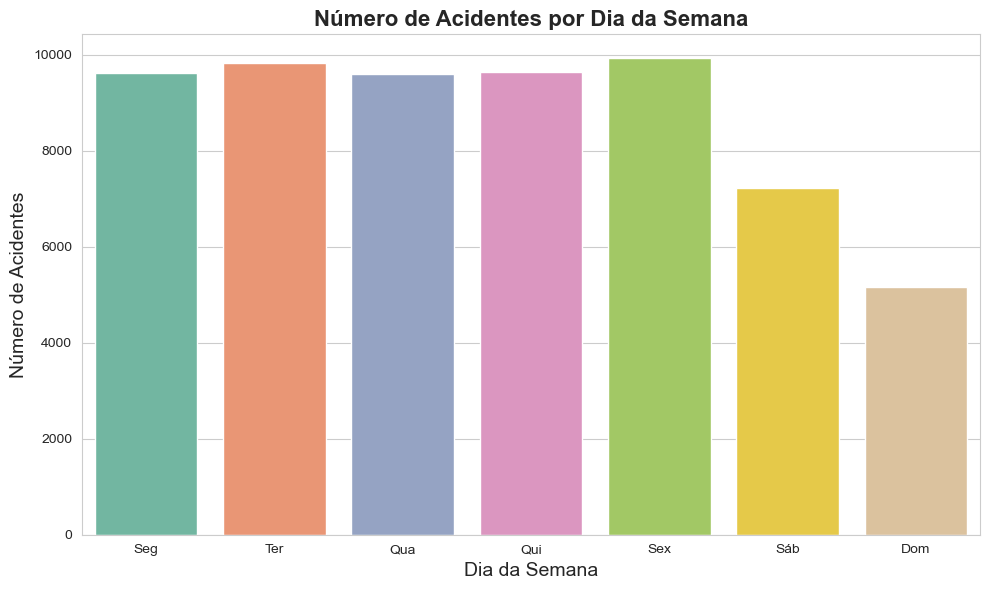

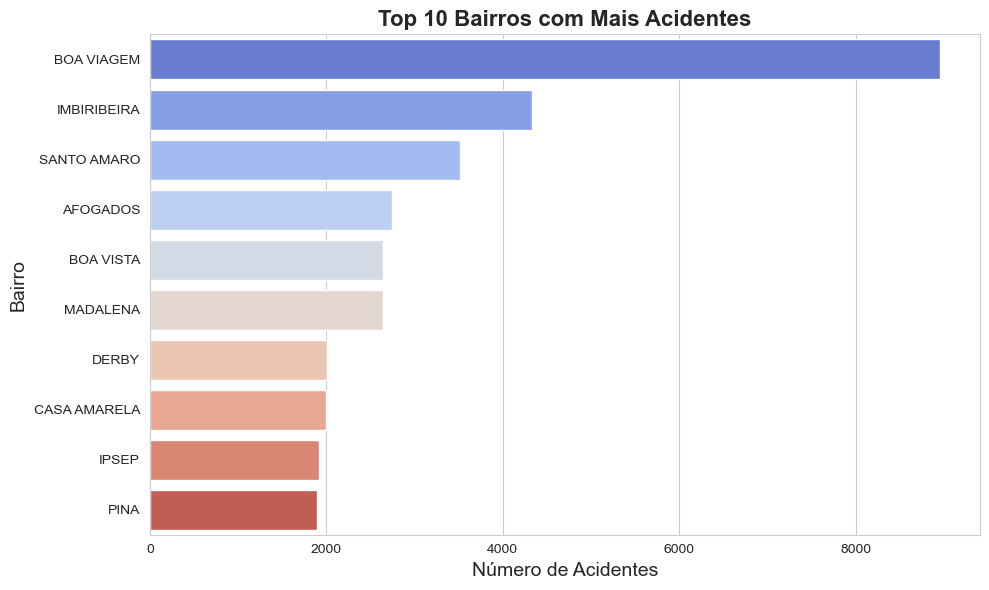

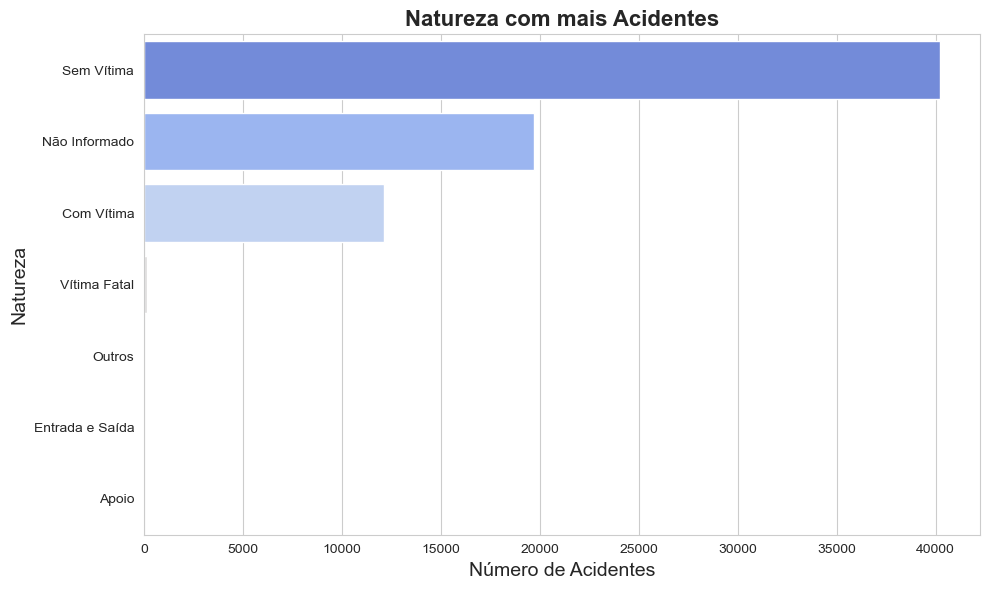

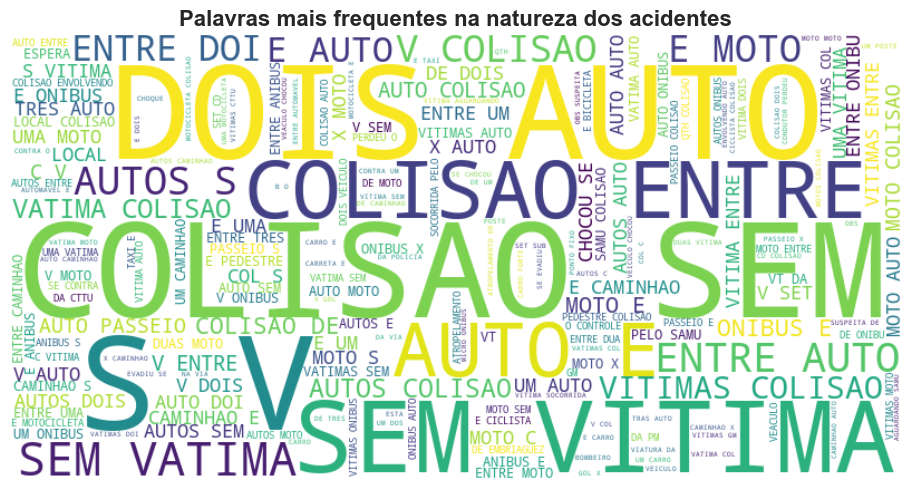

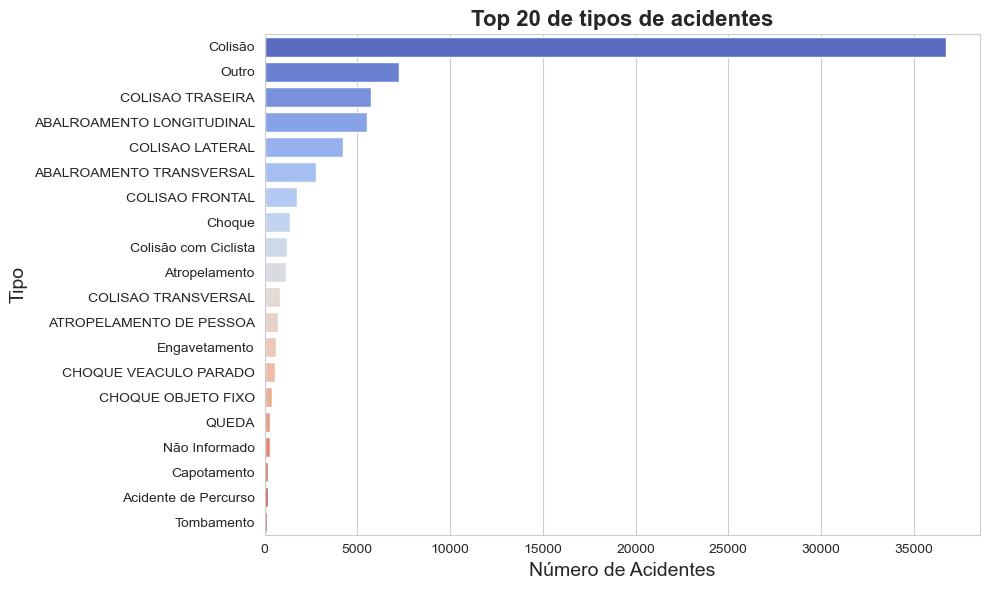

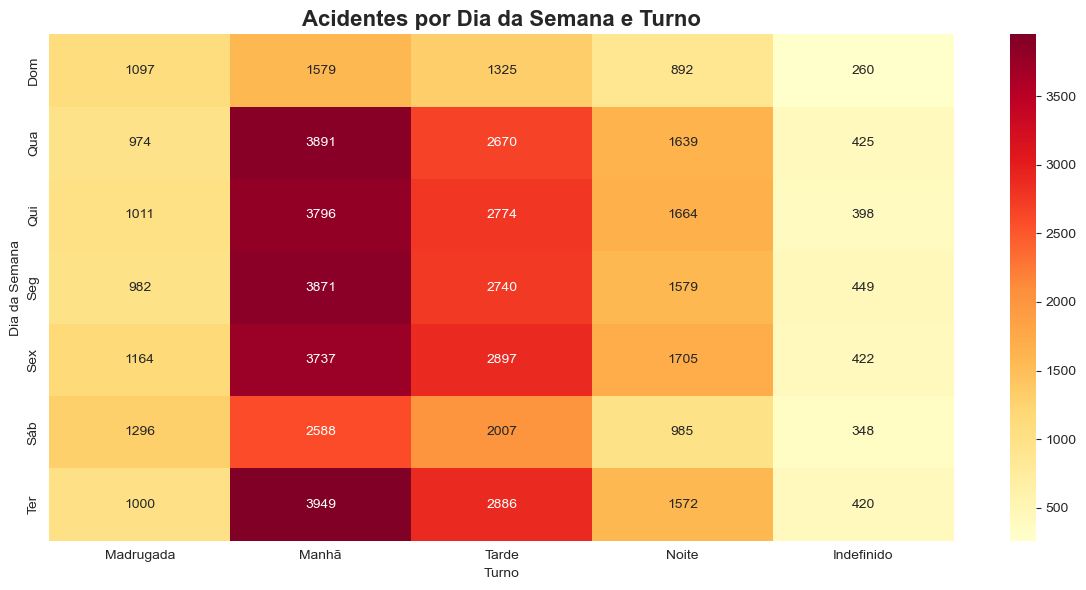

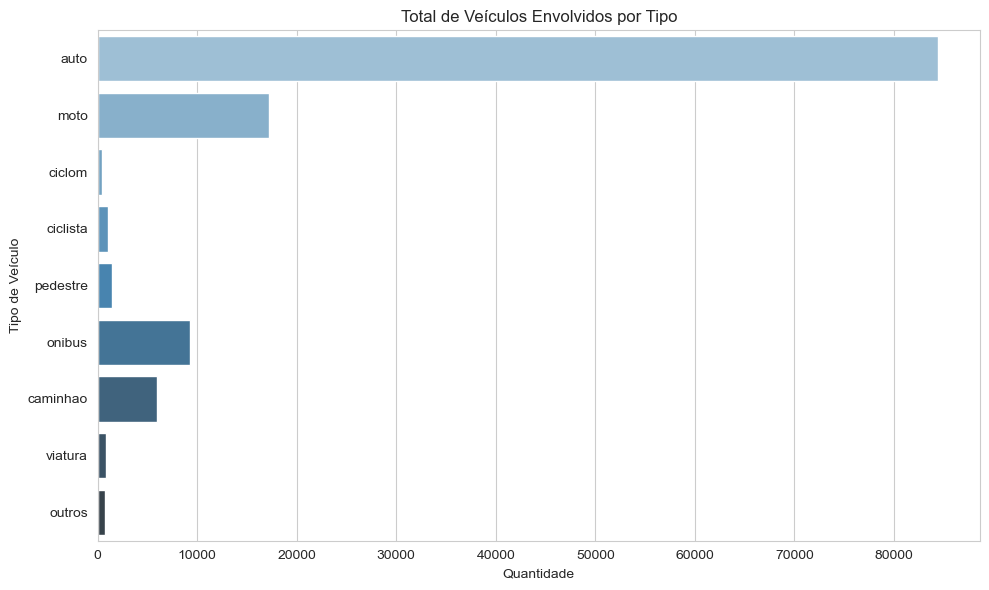

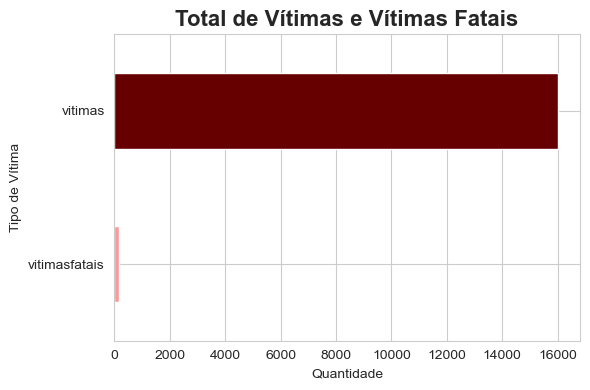

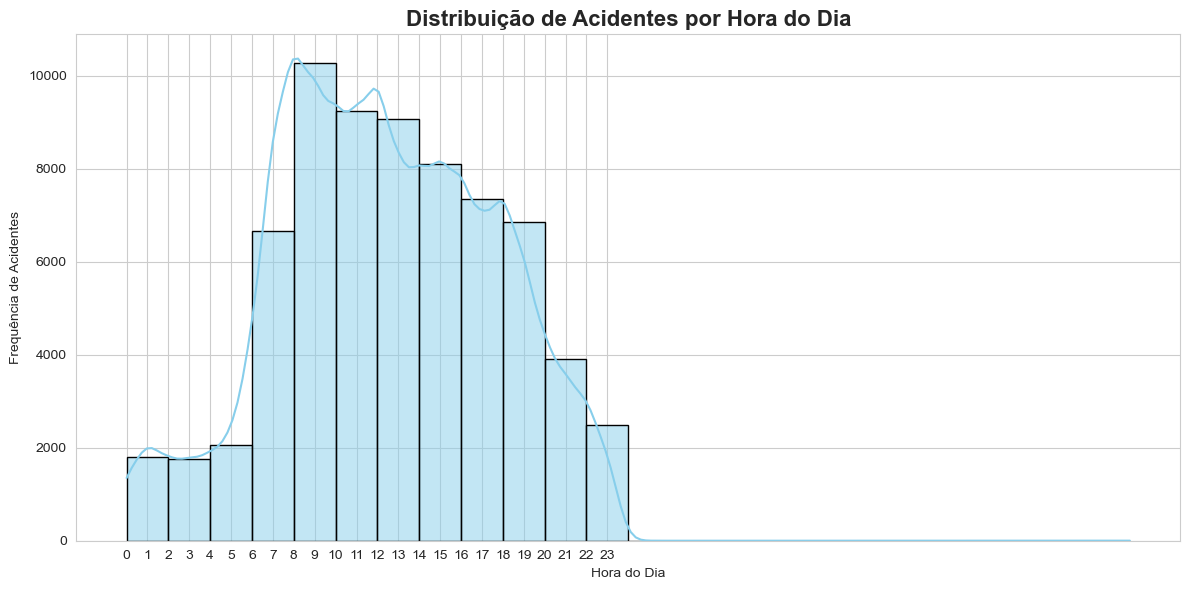

In [19]:
# 3. Visualizações iniciais

# Acidentes por ano
sns.set_style('whitegrid')
palette = sns.color_palette('pastel')

# 1. Acidentes por ano
acidentes_ano = df['ano'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=acidentes_ano.index, y=acidentes_ano.values, marker='o', linewidth=2.5, color='teal')
plt.title('Número de Acidentes por Ano', fontsize=16, weight='bold')
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Número de Acidentes', fontsize=14)
plt.tight_layout()
plt.show()


# 2. Acidentes por dia da semana
df['dia_nome'] = df['dia_semana'].map(dict(enumerate(ordem_dias)))

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='dia_nome', order=ordem_dias, palette='Set2')
plt.title('Número de Acidentes por Dia da Semana', fontsize=16, weight='bold')
plt.xlabel('Dia da Semana', fontsize=14)
plt.ylabel('Número de Acidentes', fontsize=14)
plt.tight_layout()
plt.show()

# 3. Top 10 bairros com mais acidentes
top_bairros = df['bairro'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_bairros.values, y=top_bairros.index, palette='coolwarm')
plt.title('Top 10 Bairros com Mais Acidentes', fontsize=16, weight='bold')
plt.xlabel('Número de Acidentes', fontsize=14)
plt.ylabel('Bairro', fontsize=14)
plt.tight_layout()
plt.show()

# 4. Natureza com mais acidentes
top_natureza = df['natureza_acidente'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=top_natureza.values, y=top_natureza.index, palette='coolwarm')
plt.title('Natureza com mais Acidentes', fontsize=16, weight='bold')
plt.xlabel('Número de Acidentes', fontsize=14)
plt.ylabel('Natureza', fontsize=14)
plt.tight_layout()
plt.show()

texto = ' '.join(df['descricao'].dropna().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(texto)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes na natureza dos acidentes', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# 5. Top 20 tipo com mais acidentes
tipo = df['tipo'].value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=tipo.values, y=tipo.index, palette='coolwarm')
plt.title('Top 20 de tipos de acidentes', fontsize=16, weight='bold')
plt.xlabel('Número de Acidentes', fontsize=14)
plt.ylabel('Tipo', fontsize=14)
plt.tight_layout()
plt.show()

# 6. Acidentes por turno

turno = df['turno'].value_counts()
tabela = pd.crosstab(df['dia_nome'], df['turno'])
plt.figure(figsize=(12, 6))
sns.heatmap(tabela, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Acidentes por Dia da Semana e Turno', fontsize=16, weight='bold')
plt.xlabel('Turno')
plt.ylabel('Dia da Semana')
plt.tight_layout()
plt.show()

# 7. Acidentes por tipo de veiculo

plt.figure(figsize=(10, 6))
sns.barplot(x=soma_veiculos.values, y=soma_veiculos.index, palette='Blues_d')
plt.title('Total de Veículos Envolvidos por Tipo')
plt.xlabel('Quantidade')
plt.ylabel('Tipo de Veículo')
plt.tight_layout()
plt.show()

# 7. Acidentes - vitimas e vitimas fatais
plt.figure(figsize=(6, 4))
soma_vitimas.plot(kind='barh', color=['#ff9999', '#660000'])
plt.title('Total de Vítimas e Vítimas Fatais', fontsize=16, weight='bold')
plt.xlabel('Quantidade')
plt.ylabel('Tipo de Vítima')
plt.tight_layout()
plt.show()

# 8. Acidentes por hora do dia
plt.figure(figsize=(12, 6))
sns.histplot(df['hora_limpa'], bins=24, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribuição de Acidentes por Hora do Dia', fontsize=16, weight='bold')
plt.xlabel('Hora do Dia')
plt.ylabel('Frequência de Acidentes')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()




Analise de registros sem data

In [20]:
# Total de registros
total = len(df)

# Total de registros sem data
total_sem_data = df['data_unificada'].isnull().sum()

# Total de registros com data
total_com_data = total - total_sem_data

# Proporção de registros sem data
proporcao_sem_data = (total_sem_data / total) * 100

# Proporção de registros com data
proporcao_com_data = (total_com_data / total) * 100

# Mostra o resultado
print(f"Total de registros: {total}")
print(f"Com data: {total_com_data} ({proporcao_com_data:.2f}%)")
print(f"Sem data: {total_sem_data} ({proporcao_sem_data:.2f}%)")


Total de registros: 72255
Com data: 60992 (84.41%)
Sem data: 11263 (15.59%)


# Série temporal

In [21]:
# 1. Filtrar os dados com data
df_com_data = df[df['data_unificada'].notnull()].copy()

# 2. Garantir formato datetime
df_com_data['data_unificada'] = pd.to_datetime(df_com_data['data_unificada'])

# 3. Criar a série temporal (número de acidentes por dia)
serie = df_com_data.groupby('data_unificada').size()
serie = serie.asfreq('D')  # frequência diária


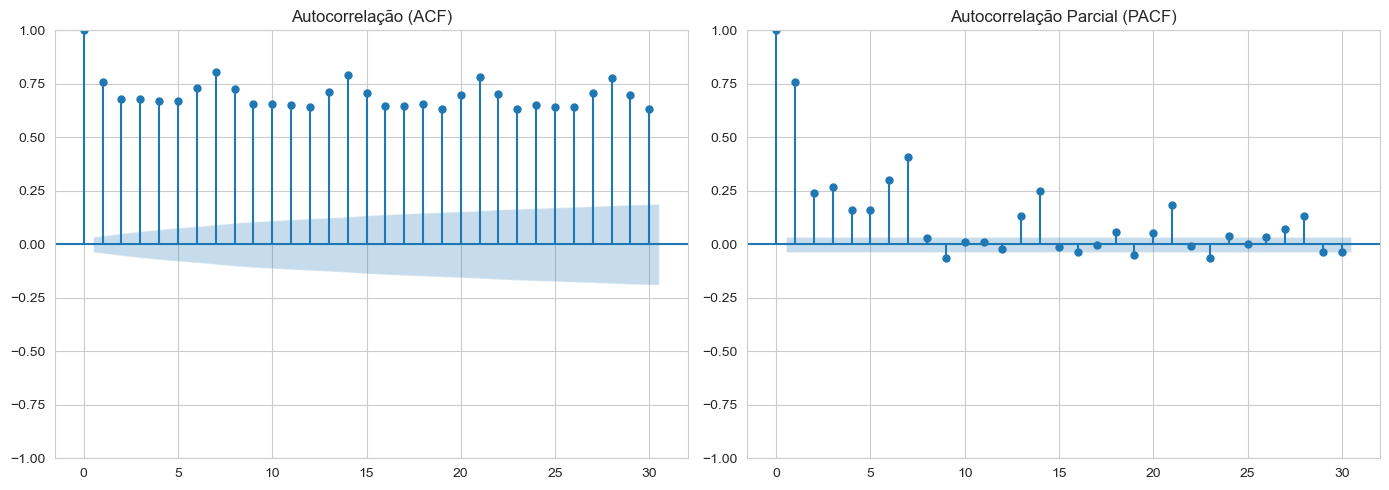

In [22]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plot_acf(serie.dropna(), lags=30, ax=plt.gca())
plt.title("Autocorrelação (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(serie.dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.title("Autocorrelação Parcial (PACF)")

plt.tight_layout()
plt.show()


🔎 Decomposição com período = 7


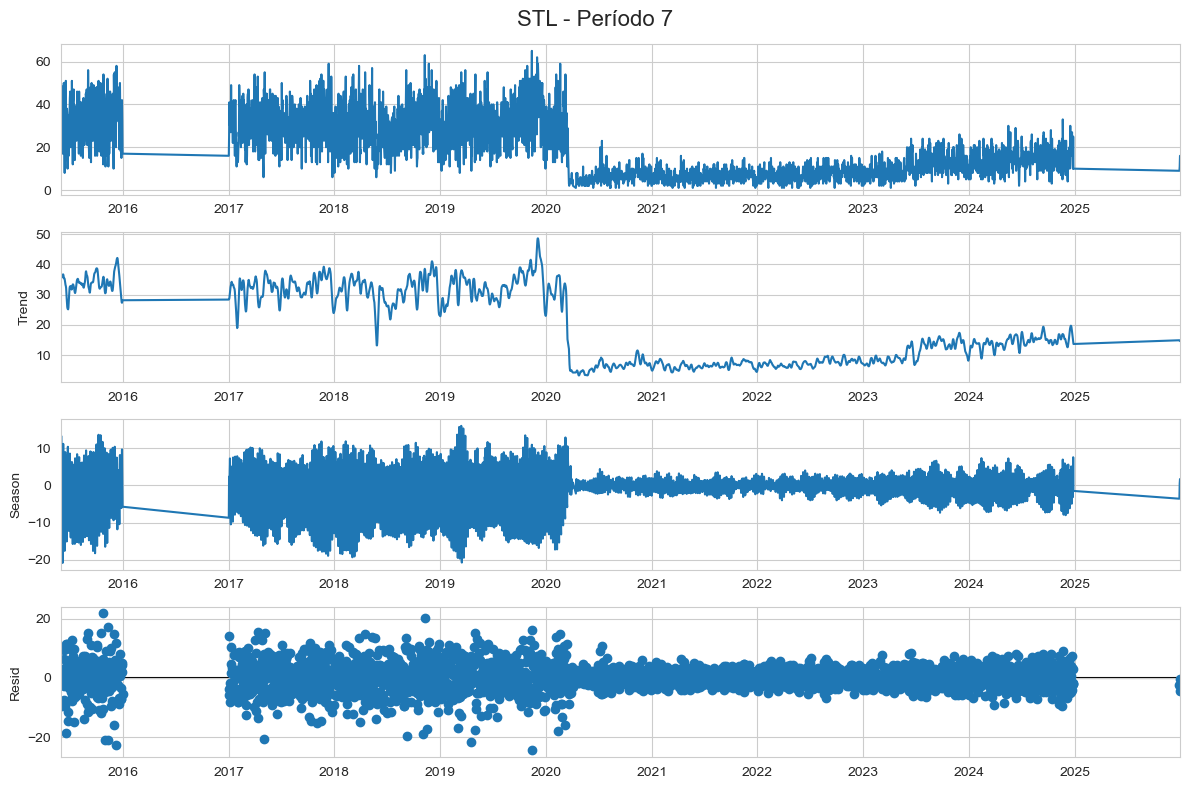


🔎 Decomposição com período = 30


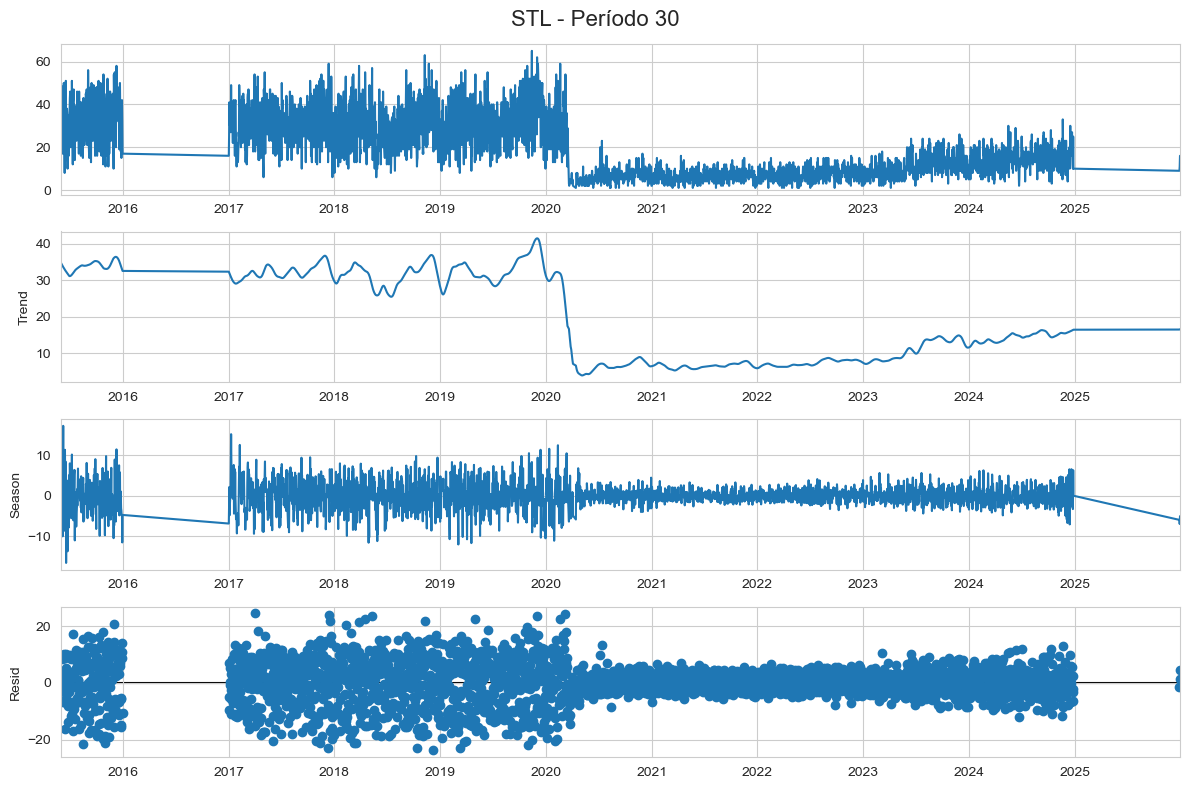


🔎 Decomposição com período = 365


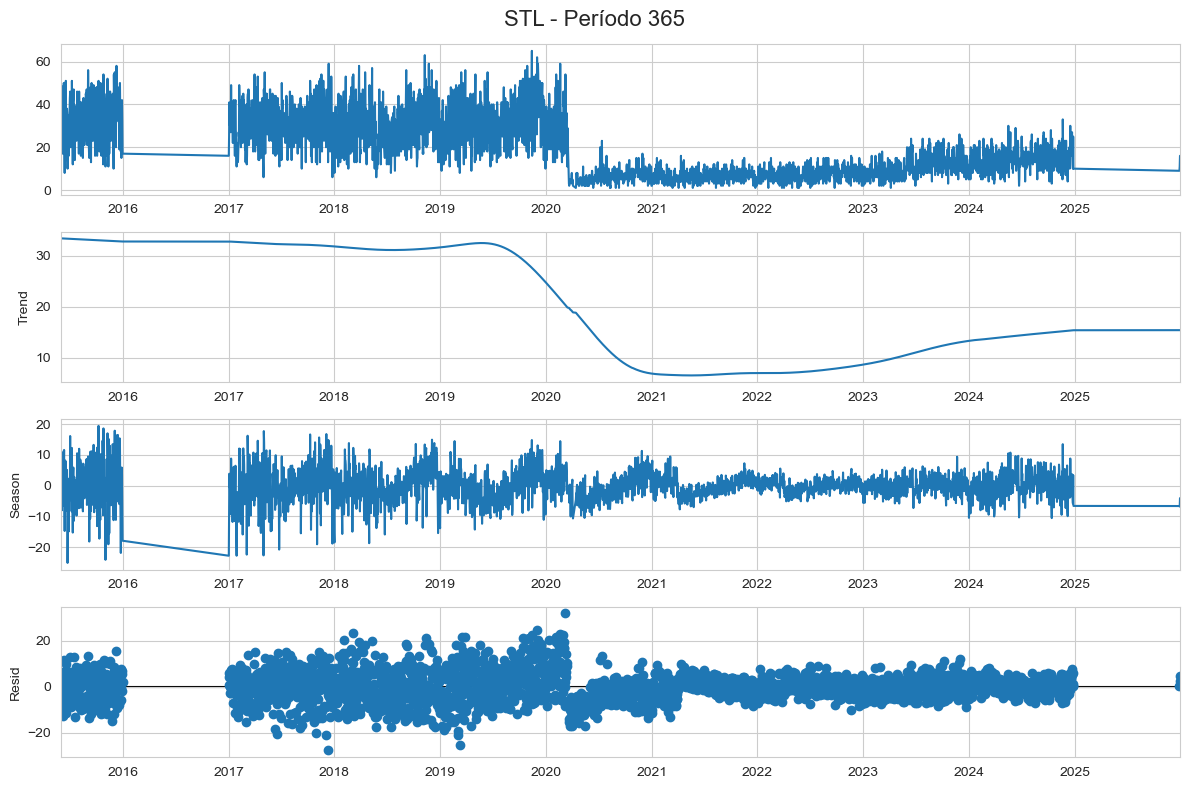

In [23]:
for p in [7, 30, 365]:
    print(f'\n🔎 Decomposição com período = {p}')
    
    stl = STL(serie.dropna(), period=p)
    resultado = stl.fit()
    
    fig = resultado.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle(f"STL - Período {p}", fontsize=16)
    plt.tight_layout()
    plt.show()




In [24]:
resultado = adfuller(serie.dropna())

print("Estatística ADF:", resultado[0])
print("p-valor:", resultado[1])
print("Valores Críticos:")
for chave, valor in resultado[4].items():
    print(f"   {chave}: {valor}")

if resultado[1] < 0.05:
    print("✅ A série é estacionária (rejeita H0)")
else:
    print("❌ A série NÃO é estacionária (não rejeita H0)")

Estatística ADF: -1.7635511476766657
p-valor: 0.3987017066439767
Valores Críticos:
   1%: -3.432471474720639
   5%: -2.8624773344098653
   10%: -2.5672689661377133
❌ A série NÃO é estacionária (não rejeita H0)


In [25]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # evita divisão por zero
    return np.mean(diff) * 100


## Arima

In [26]:
from src.dividir_modelagem import dividir_modelagem
from src.modelo_arima import modelar_arima_automatico

# 3. Cria a série temporal diária
serie = (
    df_com_data
    .groupby('data_unificada')
    .size()
)

full_index = pd.date_range(start=serie.index.min(), end=serie.index.max(), freq='D')
serie = serie.reindex(full_index).fillna(0)

# 4. Divide em treino, validação e teste
y_train, y_val, y_test = dividir_modelagem(serie)

# 5. Modela com ARIMA automático
resultados_auto = modelar_arima_automatico(y_train, y_val, y_test)

# 6. Mostra os resultados
print(f"\nOrdem final encontrada: {resultados_auto['melhor_ordem']}")
print(f"MAE Validação: {resultados_auto['mae_val']:.2f}")
print(f"MAE Teste: {resultados_auto['mae_test']:.2f}")

Tamanho Treino: 2320, Validação: 773, Teste: 774
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16583.265, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17550.536, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17305.097, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16732.723, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17548.538, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16617.125, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16610.267, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16611.809, Time=0.86 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16303.771, Time=1.89 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=16599.874, Time=0.71 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=16344.635, Time=1.68 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=16354.867, Time=2.08 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=16597.665, Time=0.96 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   :

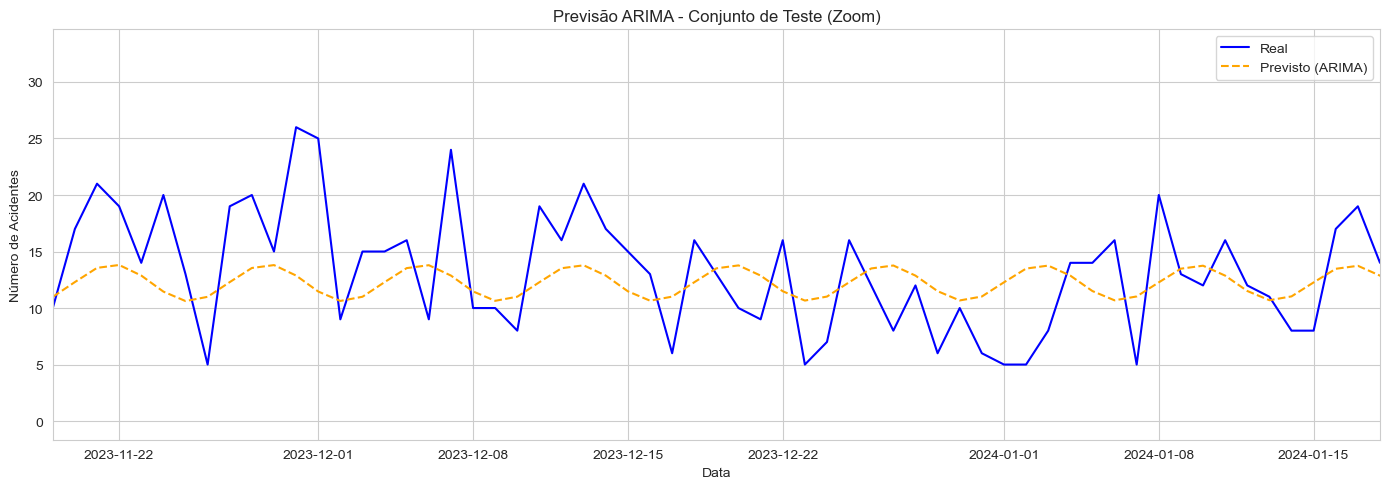

In [27]:
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label='Real', color='blue')
plt.plot(y_test.index, resultados_auto['previsao_test'], label='Previsto (ARIMA)', color='orange', linestyle='--')
plt.title('Previsão ARIMA - Conjunto de Teste (Zoom)')
plt.xlabel('Data')
plt.ylabel('Número de Acidentes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(y_test.index.min(), y_test.index.min() + pd.Timedelta(days=60))
plt.show()



In [28]:
# Obtém o modelo ARIMA treinado
modelo = resultados_auto['modelo']

# Previsão para o próximo dia
previsao_proximo_dia = modelo.predict(n_periods=1)[0]

# Exibir o valor previsto
print(f"Previsão de acidentes para o próximo dia: {previsao_proximo_dia:.2f}")


Previsão de acidentes para o próximo dia: 10.99
